In [1]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
import time
from tqdm import tqdm
import random

In [2]:
class PeopleDetector:
    def __init__(self, model_path='yolov8n.pt', confidence=0.5, nms_threshold=0.4):
       
        self.model_path = model_path
        self.confidence_threshold = confidence
        self.nms_threshold = nms_threshold
        self.is_running = False

        # COCO dataset class names
        self.class_names = [
            'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
            'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
            'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
            'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
            'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
            'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
            'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
            'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
            'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
        ]

        
        self.colors = [
            (255, 0, 0),    # Blue
            (0, 255, 0),    # Green
            (0, 0, 255),    # Red
            (255, 255, 0),  # Cyan
            (255, 0, 255),  # Magenta
            (0, 255, 255),  # Yellow
        ]

        self.model = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def load_model(self):
        # Load the YOLO model
        try:
            print(f"Loading YOLO model from: {self.model_path}")
            print(f"Using device: {self.device}")

            if not os.path.exists(self.model_path):
                print(f"Model not found at {self.model_path}, downloading YOLOv8n...")
                self.model = YOLO('yolov8n.pt')
            else:
                self.model = YOLO(self.model_path)

            print("Model loaded successfully!")
            return True

        except Exception as e:
            print(f"Error loading model: {e}")
            return False

    def detect_people(self, frame):
       
        try:
            results = self.model(frame, verbose=False)
            detections = []

            for result in results:
                boxes = result.boxes
                if boxes is not None:
                    for box in boxes:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        confidence = float(box.conf[0])
                        class_id = int(box.cls[0])
                        class_name = self.class_names[class_id]

                        if class_id == 0 and confidence >= self.confidence_threshold:
                            detections.append({
                                'bbox': (int(x1), int(y1), int(x2), int(y2)),
                                'confidence': confidence,
                                'class_id': class_id,
                                'class_name': class_name
                            })

            return detections

        except Exception as e:
            print(f"Error in people detection: {e}")
            return []

    def draw_detections(self, frame, detections):
       
        for i, detection in enumerate(detections):
            x1, y1, x2, y2 = detection['bbox']
            confidence = detection['confidence']
            class_name = detection['class_name']
            color = self.colors[i % len(self.colors)]

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            label = f"{class_name} {confidence:.1%}"
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)

            cv2.rectangle(frame, (x1, y1 - text_height - 10), (x1 + text_width + 10, y1), color, -1)
            cv2.putText(frame, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        return frame

    def process_video(self, video_path):
        
        try:
            print(f"Processing video: {video_path}")
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                raise ValueError(f"Could not open video file: {video_path}")

            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            print(f"Video info: {frame_width}x{frame_height}, {fps:.2f} FPS, {total_frames} frames")

            output_dir = Path("outputs")
            output_dir.mkdir(exist_ok=True)

            output_path = output_dir / f"output_{Path(video_path).name}"
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

            frame_count = 0
            people_count = 0
            start_time = time.time()

            print("Starting video processing...")

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                detections = self.detect_people(frame)
                people_count += len(detections)
                output_frame = self.draw_detections(frame.copy(), detections)

                current_time = time.time()
                elapsed_time = current_time - start_time
                current_fps = frame_count / elapsed_time if elapsed_time > 0 else 0

                info_text = f"Frame: {frame_count}/{total_frames} | People: {len(detections)} | FPS: {current_fps:.1f}"
                cv2.putText(output_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                writer.write(output_frame)

                if frame_count % 30 == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"Progress: {progress:.1f}% | People detected: {people_count}")

            cap.release()
            writer.release()

            processing_time = time.time() - start_time
            average_fps = frame_count / processing_time if processing_time > 0 else 0

            print(f"\nVideo processing completed!")
            print(f"Processing time: {processing_time:.2f} seconds")
            print(f"Total frames processed: {frame_count}")
            print(f"Total people detected: {people_count}")
            print(f"Average FPS: {average_fps:.2f}")
            print(f"Output saved to: {output_path}")

            return {
                'output_path': str(output_path),
                'total_frames': frame_count,
                'total_people': people_count,
                'processing_time': processing_time,
                'average_fps': average_fps
            }

        except Exception as e:
            print(f"Error processing video: {e}")
            return None

    def process_webcam(self):
        # Process webcam feed in real-time
        print("Starting webcam detection...")
        print("Press 'q' to quit")

        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Could not open webcam")
            return

        self.is_running = True
        frame_count = 0
        start_time = time.time()

        while self.is_running:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            detections = self.detect_people(frame)
            output_frame = self.draw_detections(frame.copy(), detections)

            current_time = time.time()
            elapsed_time = current_time - start_time
            current_fps = frame_count / elapsed_time if elapsed_time > 0 else 0

            info_text = f"People: {len(detections)} | FPS: {current_fps:.1f}"
            cv2.putText(output_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            cv2.imshow('People Detection', output_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.is_running = False

    def stop(self):
        self.is_running = False


In [3]:
def analyze_dataset():
    print("Dataset Analysis")
    
    # Check training data
    train_dir = Path("train/train")
    if train_dir.exists():
        train_images = list(train_dir.glob("*.jpg")) + list(train_dir.glob("*.png"))
        print(f"Training images: {len(train_images)}")
        
        # Show sample images
        if train_images:
            print("\nSample training images:")
            sample_images = random.sample(train_images, min(5, len(train_images)))
            fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 3))
            if len(sample_images) == 1:
                axes = [axes]
            
            for i, img_path in enumerate(sample_images):
                img = cv2.imread(str(img_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img_rgb)
                axes[i].set_title(f"Sample {i+1}")
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    # Check validation data
    valid_dir = Path("valid/valid")
    if valid_dir.exists():
        valid_images = list(valid_dir.glob("*.jpg")) + list(valid_dir.glob("*.png"))
        print(f"Validation images: {len(valid_images)}")
    
    # Check test data
    test_dir = Path("test/test")
    if test_dir.exists():
        test_images = list(test_dir.glob("*.jpg")) + list(test_dir.glob("*.png"))
        print(f"Test images: {len(test_images)}")


In [4]:
print("People Detection Model")
detector = PeopleDetector(confidence=0.5, nms_threshold=0.4)
success = detector.load_model()

if not success:
    print("Failed to load model. Please check the model path.")
else:
    print("Model loaded successfully!")

People Detection Model
Loading YOLO model from: yolov8n.pt
Using device: cpu
Model loaded successfully!
Model loaded successfully!


Dataset Analysis
Training images: 15210

Sample training images:


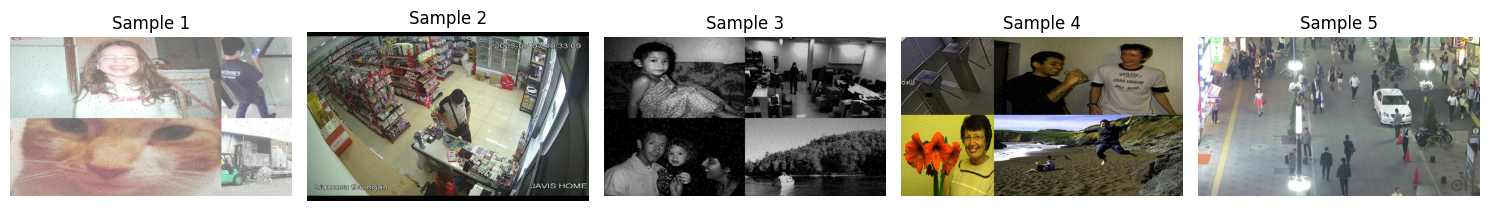

Validation images: 1431
Test images: 760


In [5]:
analyze_dataset()

In [6]:
def test_on_training_images(num_samples=5):
    print(f"\n=== Testing Detection on {num_samples} Training Images ===")
    
    train_dir = Path("train/train")
    if not train_dir.exists():
        print("Training directory not found!")
        return
    
    train_images = list(train_dir.glob("*.jpg")) + list(train_dir.glob("*.png"))
    if not train_images:
        print("No training images found!")
        return
    
    sample_images = random.sample(train_images, min(num_samples, len(train_images)))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(5 * num_samples, 8))
    if num_samples == 1:
        axes = axes.reshape(2, 1)
    
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        
        detections = detector.detect_people(img)
        output_img = detector.draw_detections(img.copy(), detections)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        output_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f"Original\n{img_path.name}")
        axes[0, i].axis('off')
        
        confidences = [f"{d['confidence']:.2f}" for d in detections]
        axes[1, i].imshow(output_rgb)
        axes[1, i].set_title(f"Detections: {len(detections)}\nConfidence: {confidences}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()



=== Testing Detection on 3 Training Images ===


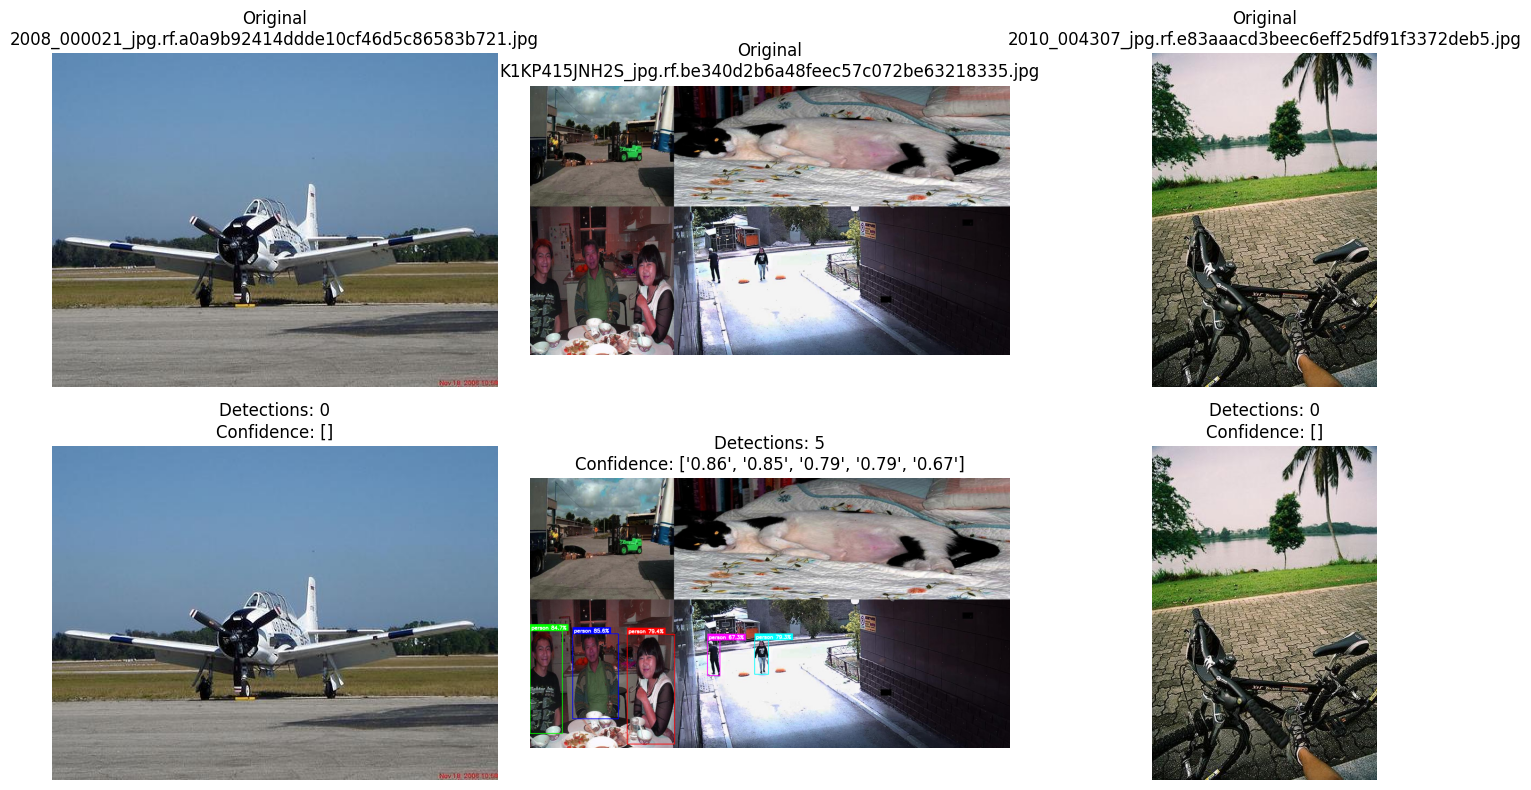

In [7]:
test_on_training_images(num_samples=3)

In [8]:
def performance_analysis():
 
    print("\n Performance Analysis")
    
    train_dir = Path("train/train")
    if not train_dir.exists():
        print("Training directory not found!")
        return
    
    train_images = list(train_dir.glob("*.jpg")) + list(train_dir.glob("*.png"))
    if not train_images:
        print("No training images found!")
        return
    
    
    test_images = random.sample(train_images, min(20, len(train_images)))
    
    results = []
    total_time = 0
    
    print(f"Testing on {len(test_images)} images...")
    
    for img_path in tqdm(test_images):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
       
        start_time = time.time()
        detections = detector.detect_people(img)
        inference_time = time.time() - start_time
        
        total_time += inference_time
        
        results.append({
            'image': img_path.name,
            'detections': len(detections),
            'inference_time': inference_time,
            'fps': 1.0 / inference_time if inference_time > 0 else 0,
            'avg_confidence': np.mean([d['confidence'] for d in detections]) if detections else 0
        })
    
    
    df = pd.DataFrame(results)
    
    print(f"\nPerformance Summary:")
    print(f"Total images processed: {len(df)}")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Average inference time: {df['inference_time'].mean():.4f} seconds")
    print(f"Average FPS: {df['fps'].mean():.2f}")
    print(f"Average detections per image: {df['detections'].mean():.2f}")
    print(f"Average confidence: {df['avg_confidence'].mean():.3f}")
    
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Inference time distribution
    axes[0, 0].hist(df['inference_time'], bins=20, alpha=0.7, color='blue')
    axes[0, 0].set_title('Inference Time Distribution')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Frequency')
    
    # FPS distribution
    axes[0, 1].hist(df['fps'], bins=20, alpha=0.7, color='green')
    axes[0, 1].set_title('FPS Distribution')
    axes[0, 1].set_xlabel('FPS')
    axes[0, 1].set_ylabel('Frequency')
    
  
    axes[1, 0].hist(df['detections'], bins=20, alpha=0.7, color='red')
    axes[1, 0].set_title('Detections per Image')
    axes[1, 0].set_xlabel('Number of Detections')
    axes[1, 0].set_ylabel('Frequency')
    
    
    axes[1, 1].hist(df['avg_confidence'], bins=20, alpha=0.7, color='orange')
    axes[1, 1].set_title('Average Confidence Distribution')
    axes[1, 1].set_xlabel('Confidence')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return df



 Performance Analysis
Testing on 20 images...


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 18.67it/s]



Performance Summary:
Total images processed: 20
Total processing time: 1.00 seconds
Average inference time: 0.0499 seconds
Average FPS: 20.76
Average detections per image: 2.65
Average confidence: 0.626


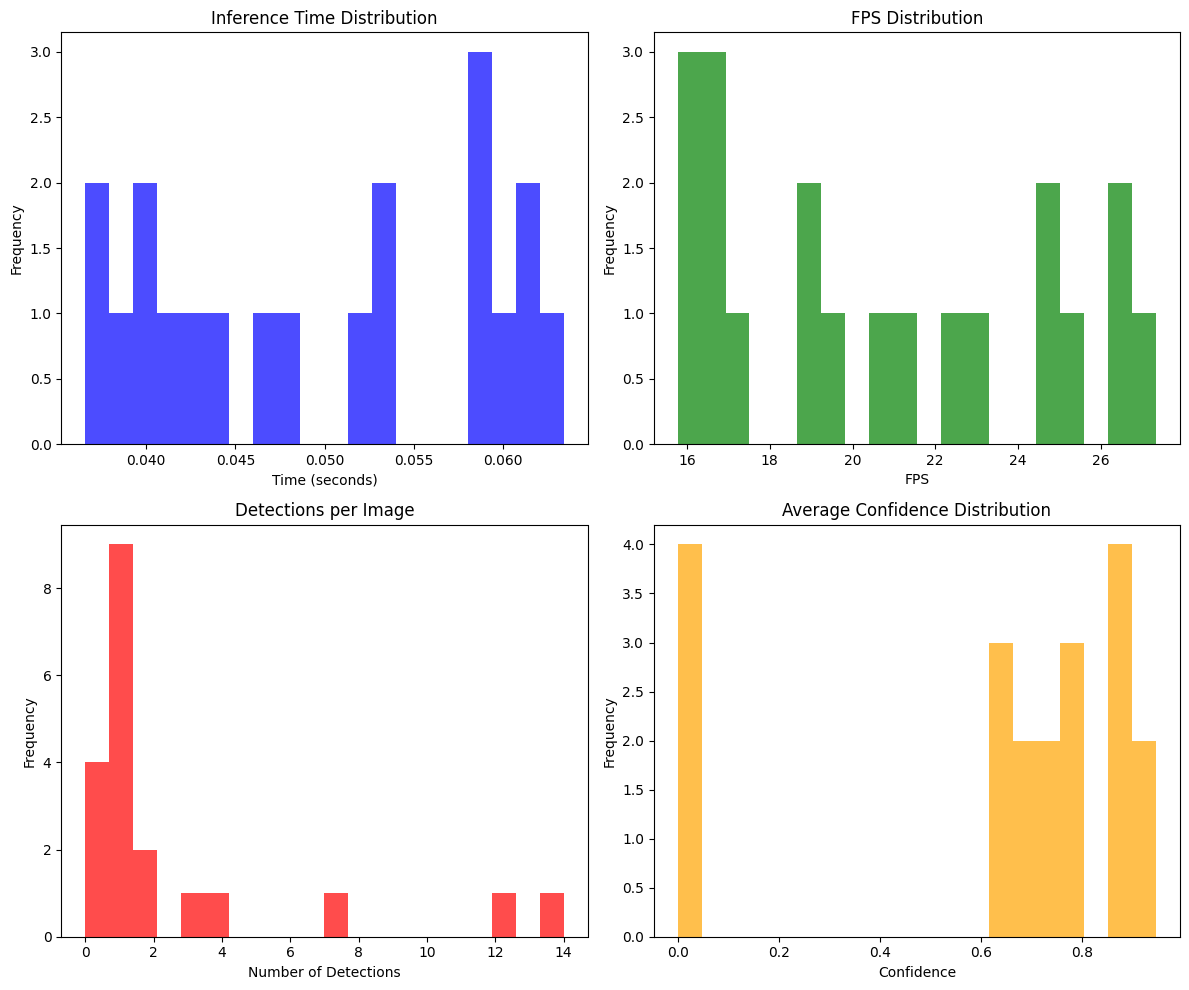

In [9]:
performance_df = performance_analysis()

In [10]:
def interactive_demo():
    print("\n Interactive Detection Demo ")
    print("This will open your webcam for real-time detection.")
    print("Press 'q' to quit, 'c' to change confidence threshold")
    
    
    detector.confidence_threshold = 0.5
    print(f"Current confidence threshold: {detector.confidence_threshold}")
    
    # Uncomment the line below to start webcam detection
    # detector.process_webcam()

In [11]:
def save_results():
    
    print("\n Saving Results ")
    
    
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    
   
    model_info = {
        'model_path': detector.model_path,
        'confidence_threshold': detector.confidence_threshold,
        'nms_threshold': detector.nms_threshold,
        'device': detector.device,
        'class_names': detector.class_names
    }
    
    # Save as JSON
    import json
    with open(results_dir / "model_info.json", "w") as f:
        json.dump(model_info, f, indent=2)
    
    print(f"Model information saved to: {results_dir / 'model_info.json'}")
    
    
    if 'performance_df' in globals():
        performance_df.to_csv(results_dir / "performance_results.csv", index=False)
        print(f"Performance results saved to: {results_dir / 'performance_results.csv'}")


In [12]:
save_results()

print("\n People Detection Model Complete ")
print("The model is ready for use!")
print("You can now:")
print("1. Test on new images")
print("2. Process videos")
print("3. Use webcam for real-time detection")
print("4. Adjust confidence thresholds")


 Saving Results 
Model information saved to: results/model_info.json
Performance results saved to: results/performance_results.csv

 People Detection Model Complete 
The model is ready for use!
You can now:
1. Test on new images
2. Process videos
3. Use webcam for real-time detection
4. Adjust confidence thresholds


In [13]:
detector.process_webcam()

Starting webcam detection...
Press 'q' to quit


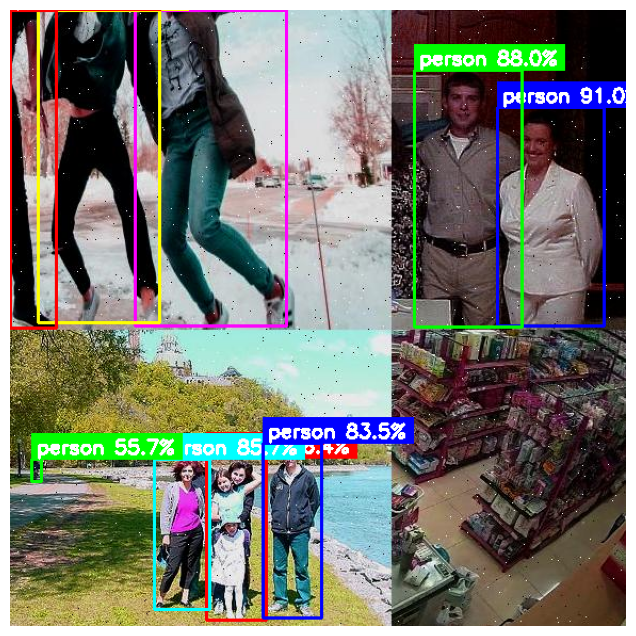

In [14]:
# test on any image
image_path = "train/train/0eQHR0-4wTV5O3ypF_jpg.rf.7644125271be7e165c048803dc9ff8e6.jpg"
image = cv2.imread(image_path)
detections = detector.detect_people(image)
output_image = detector.draw_detections(image.copy(), detections)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()